In [15]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import scipy.optimize as opt
import copy


In [16]:
# Set seeds for reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)


In [17]:
# Parameters
num_nodes = 100
anchors = 25
unknowns = num_nodes - anchors
communication_range = 14.5

# Datasets
num_train_graphs = 100  # Number of graphs for training
num_test_graphs = 20    # Number of graphs for testing


In [18]:
def generate_random_graph(seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
    
    # Generate true locations
    truth_location_list = [[random.uniform(i[0], i[1]), random.uniform(j[0], j[1])] 
                           for i in [[0,2], [2,4], [4,6], [6,8], [8,10]] 
                           for j in [[0,2], [2,4], [4,6], [6,8], [8,10]] ] \
                          + [[random.uniform(0,10), random.uniform(0,10)] for _ in range(75)]
    
    truth_location_list = np.array(truth_location_list)
    
    # Initial estimates
    estimate_location_list = np.zeros((num_nodes, 2))
    estimate_location_list[:anchors] = truth_location_list[:anchors]  # Anchors know their location
    estimate_location_list[anchors:] = np.random.uniform(0, 10, size=(unknowns, 2))  # Unknown nodes
    
    # Build the graph
    tree = KDTree(truth_location_list)
    edges = tree.query_pairs(r=communication_range)
    edges = list(edges)
    edge_index = np.array(edges + [(j, i) for (i, j) in edges]).T
    
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    
    # Node features
    x = np.zeros((num_nodes, 2))
    x[:anchors] = truth_location_list[:anchors]  # Anchors
    x[anchors:] = estimate_location_list[anchors:]  # Unknowns
    
    x = torch.tensor(x, dtype=torch.float)
    
    # Labels and masks
    y = torch.tensor(truth_location_list, dtype=torch.float)
    
    anchor_mask = torch.zeros(num_nodes, dtype=torch.bool)
    anchor_mask[:anchors] = True
    
    unknown_mask = ~anchor_mask
    
    # Create data object
    data = Data(x=x, edge_index=edge_index, y=y)
    data.anchor_mask = anchor_mask
    data.unknown_mask = unknown_mask
    
    return data


In [19]:
# Generate training data
train_data_list = [generate_random_graph(seed=i) for i in range(num_train_graphs)]

# Generate test data
test_data_list = [generate_random_graph(seed=1000 + i) for i in range(num_test_graphs)]


In [20]:
# Create data loaders
train_loader = DataLoader(train_data_list, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data_list, batch_size=1, shuffle=False)


In [21]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
            
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [22]:
# Instantiate model and optimizer
model = GCN(input_dim=2, hidden_dim=32, output_dim=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [23]:
# Training loop
model.train()
loss_history = []

for epoch in range(100):
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        
        # Compute loss only for unknown nodes
        loss = F.mse_loss(out[data.unknown_mask], data.y[data.unknown_mask])
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {avg_loss:.4f}')


Epoch 0, Loss: 24.5143
Epoch 10, Loss: 8.3844
Epoch 20, Loss: 8.3831
Epoch 30, Loss: 8.3875
Epoch 40, Loss: 8.3906
Epoch 50, Loss: 8.3896
Epoch 60, Loss: 8.3962
Epoch 70, Loss: 8.3848
Epoch 80, Loss: 8.3805
Epoch 90, Loss: 8.3819


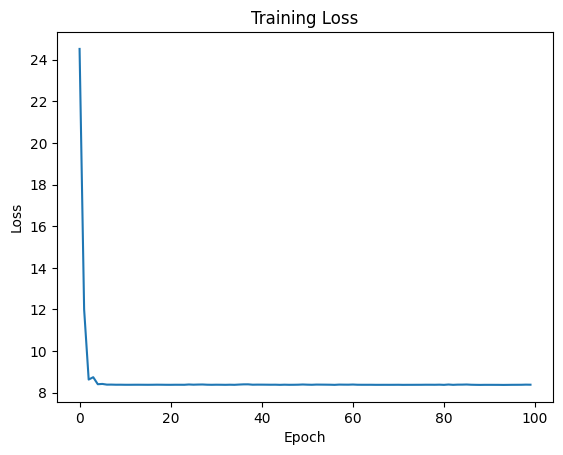

In [24]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [25]:
def multilateration_method(data):
    # Extract data
    truth_location_list = data.y.numpy()
    estimated_accuracy_list = np.array([1] * anchors + [0] * unknowns)
    estimate_location_list = np.zeros((num_nodes, 2))
    estimate_location_list[:anchors] = truth_location_list[:anchors]
    estimate_location_list[anchors:] = np.random.uniform(0, 10, size=(unknowns, 2))
    
    # Initialize history data structure
    neighbor_history = {i: {} for i in range(num_nodes)}
    max_iterations = 10
    
    for iteration in range(max_iterations):
        estimate_location_list_old = copy.deepcopy(estimate_location_list)
        estimated_accuracy_list_old = copy.deepcopy(estimated_accuracy_list)
        for idx in range(num_nodes):
            if estimated_accuracy_list_old[idx] == 1:
                continue  # Skip anchors
            neighbor_list = []
            # Find neighbors
            neighbor_indices = data.edge_index[1][data.edge_index[0] == idx].numpy()
            neighbor_indices = np.unique(neighbor_indices)
            for neighbor_idx in neighbor_indices:
                if estimated_accuracy_list_old[neighbor_idx] >= 0.25:
                    # Use neighbor's estimated location and compute distance
                    neighbor_loc = estimate_location_list[neighbor_idx]
                    distance = np.linalg.norm(truth_location_list[idx] - truth_location_list[neighbor_idx])
                    # Simulate RSSI with noise
                    rssi = -17.2 * np.log10(distance*1000) - 62.4 + np.random.normal(0, 3)
                    noisy_distance = 10**((rssi + 62.4)/-17.2)/1000
                    # Update history data
                    if neighbor_idx not in neighbor_history[idx]:
                        neighbor_history[idx][neighbor_idx] = []
                    neighbor_history[idx][neighbor_idx].append(noisy_distance)
                    # Use average of historical distances
                    avg_noisy_distance = np.mean(neighbor_history[idx][neighbor_idx])
                    neighbor_list.append((neighbor_loc, avg_noisy_distance))
            # Perform multilateration
            if len(neighbor_list) >= 3:
                def error_function(x):
                    return sum((np.linalg.norm(x - np.array(neighbor[0])) - neighbor[1])**2 for neighbor in neighbor_list)
                initial_guess = np.mean([neighbor[0] for neighbor in neighbor_list], axis=0)
                result = opt.minimize(error_function, initial_guess)
                if result.success:
                    estimate_location_list[idx] = result.x
                    estimated_accuracy_list[idx] = 1 - np.sqrt(result.fun / len(neighbor_list))/np.mean([neighbor[1] for neighbor in neighbor_list])
        # Check for convergence (optional)
        if np.allclose(estimate_location_list, estimate_location_list_old, atol=1e-2):
            break  # Converged
    
    # Compute errors for unknown nodes
    errors = np.linalg.norm(estimate_location_list[anchors:] - truth_location_list[anchors:], axis=1)
    return errors


In [26]:
model.eval()
errors_gcn = []
errors_multilateration = []

with torch.no_grad():
    for data in test_loader:
        out = model(data.x, data.edge_index)
        predicted_positions = out.numpy()
        true_positions = data.y.numpy()
        
        # Calculate estimation errors for unknown nodes
        error = np.linalg.norm(predicted_positions[data.unknown_mask] - true_positions[data.unknown_mask], axis=1)
        errors_gcn.extend(error)
        
        # Multilateration method errors
        error_multi = multilateration_method(data)
        errors_multilateration.extend(error_multi)


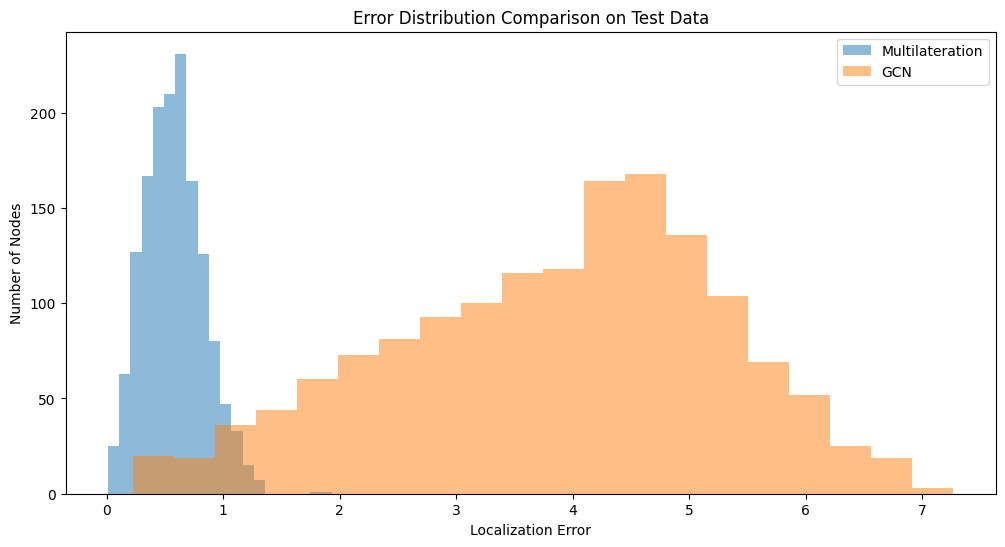

Multilateration Mean Error: 0.5777, Median Error: 0.5667
GCN Mean Error: 3.8542, Median Error: 4.0615


In [27]:
# Convert errors to numpy arrays
errors_gcn = np.array(errors_gcn)
errors_multilateration = np.array(errors_multilateration)

# Plot error distributions
plt.figure(figsize=(12, 6))

plt.hist(errors_multilateration, bins=20, alpha=0.5, label='Multilateration')
plt.hist(errors_gcn, bins=20, alpha=0.5, label='GCN')
plt.xlabel('Localization Error')
plt.ylabel('Number of Nodes')
plt.title('Error Distribution Comparison on Test Data')
plt.legend()
plt.show()

# Print mean and median errors
print(f"Multilateration Mean Error: {errors_multilateration.mean():.4f}, Median Error: {np.median(errors_multilateration):.4f}")
print(f"GCN Mean Error: {errors_gcn.mean():.4f}, Median Error: {np.median(errors_gcn):.4f}")


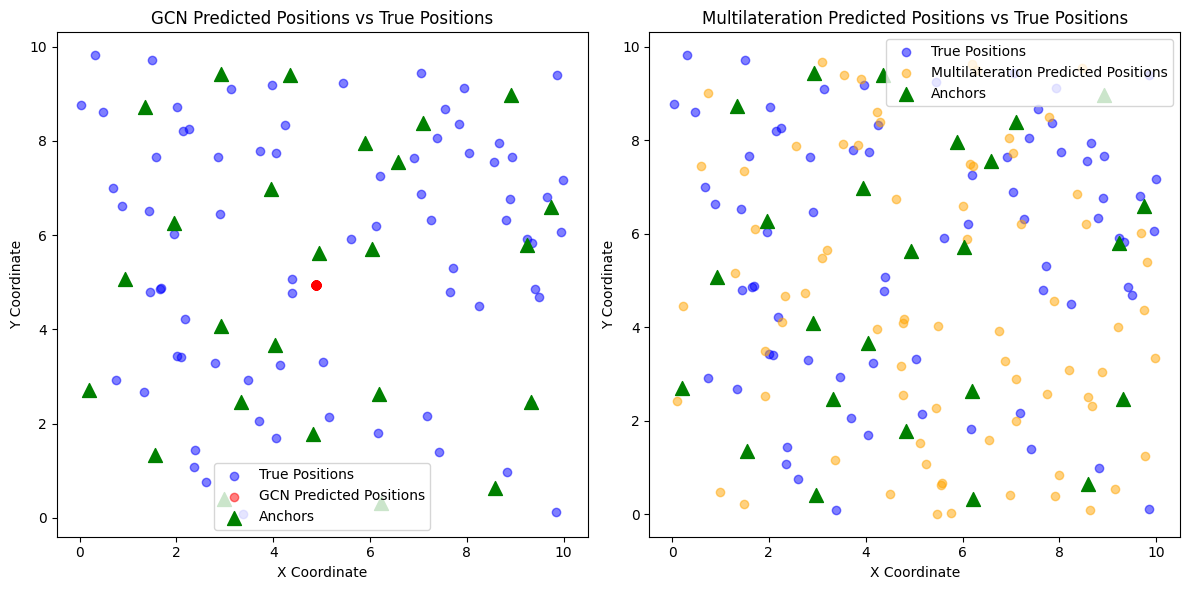

In [28]:
# Get a sample test graph
sample_data = test_data_list[0]

# GCN predictions
model.eval()
with torch.no_grad():
    out = model(sample_data.x, sample_data.edge_index)
    predicted_positions = out.numpy()
    true_positions = sample_data.y.numpy()

# Multilateration predictions
estimate_location_list = np.zeros((num_nodes, 2))
estimate_location_list[:anchors] = true_positions[:anchors]
estimate_location_list[anchors:] = np.random.uniform(0, 10, size=(unknowns, 2))
errors_multi = multilateration_method(sample_data)
multi_predicted_positions = estimate_location_list

# Plotting
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title('GCN Predicted Positions vs True Positions')
plt.scatter(true_positions[sample_data.unknown_mask][:,0], true_positions[sample_data.unknown_mask][:,1], c='blue', label='True Positions', alpha=0.5)
plt.scatter(predicted_positions[sample_data.unknown_mask][:,0], predicted_positions[sample_data.unknown_mask][:,1], c='red', label='GCN Predicted Positions', alpha=0.5)
plt.scatter(true_positions[sample_data.anchor_mask][:,0], true_positions[sample_data.anchor_mask][:,1], c='green', label='Anchors', marker='^', s=100)
plt.legend()
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.subplot(1,2,2)
plt.title('Multilateration Predicted Positions vs True Positions')
plt.scatter(true_positions[sample_data.unknown_mask][:,0], true_positions[sample_data.unknown_mask][:,1], c='blue', label='True Positions', alpha=0.5)
plt.scatter(multi_predicted_positions[sample_data.unknown_mask][:,0], multi_predicted_positions[sample_data.unknown_mask][:,1], c='orange', label='Multilateration Predicted Positions', alpha=0.5)
plt.scatter(true_positions[sample_data.anchor_mask][:,0], true_positions[sample_data.anchor_mask][:,1], c='green', label='Anchors', marker='^', s=100)
plt.legend()
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.tight_layout()
plt.show()
